In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [11]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/2-heuristiques/stock_qui_ne_turbine_pas"
output_path = study_path+"/output/20240819-1750eco-change_intra_daily_modulation_export_mps"

In [12]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [13]:
week = 7297//168+1

In [14]:
week

44

In [15]:
m = retrieve_problem(25,week,output_path,itr=1)

In [16]:
vars = m.getVariable()
len(vars)

450744

In [17]:
cons = m.getConstraint()
len(cons)

66547

In [18]:
m.solve()
m.getObjVal()

2036187144707.767

In [19]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
# df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
# df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [20]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff
0,NTCDirect::link<0_pump_open$$2_at00_hydro_open...,"[NTCDirect, link<0_pump_open$$2_at00_hydro_ope...",NTCDirect,link,0_pump_open$$2_at00_hydro_open,None,7224,hour,C,-2859.0,0.000000,0.000000
1,NTCDirect::link<0_pump_open$$2_ba00_hydro_open...,"[NTCDirect, link<0_pump_open$$2_ba00_hydro_ope...",NTCDirect,link,0_pump_open$$2_ba00_hydro_open,None,7224,hour,C,-440.0,0.000000,0.000000
2,NTCDirect::link<0_pump_open$$2_bg00_hydro_open...,"[NTCDirect, link<0_pump_open$$2_bg00_hydro_ope...",NTCDirect,link,0_pump_open$$2_bg00_hydro_open,None,7224,hour,C,-148.0,0.000000,0.000000
3,NTCDirect::link<0_pump_open$$2_cz00_hydro_open...,"[NTCDirect, link<0_pump_open$$2_cz00_hydro_ope...",NTCDirect,link,0_pump_open$$2_cz00_hydro_open,None,7224,hour,C,-438.0,0.000000,0.000000
4,NTCDirect::link<0_pump_open$$2_de00_hydro_open...,"[NTCDirect, link<0_pump_open$$2_de00_hydro_ope...",NTCDirect,link,0_pump_open$$2_de00_hydro_open,None,7224,hour,C,-1361.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
450739,HydProd::area<ro00>::hour<7391> ...,"[HydProd, area<ro00>, hour<7391>]",HydProd,area,ro00,None,7391,hour,C,0.0,1934.804786,0.000672
450740,HydProd::area<rs00>::hour<7391> ...,"[HydProd, area<rs00>, hour<7391>]",HydProd,area,rs00,None,7391,hour,C,0.0,421.000000,-0.000889
450741,HydProd::area<se03>::hour<7391> ...,"[HydProd, area<se03>, hour<7391>]",HydProd,area,se03,None,7391,hour,C,0.0,1793.000000,-0.000947
450742,HydProd::area<se04>::hour<7391> ...,"[HydProd, area<se04>, hour<7391>]",HydProd,area,se04,None,7391,hour,C,0.0,231.000000,0.000906


In [21]:
df_vars["name_var"].unique()

array(['NTCDirect', 'IntercoDirectCost', 'IntercoIndirectCost',
       'DispatchableProduction', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'HydProd'], dtype=object)

In [22]:
df_vars[df_vars.name_var.isin(['HydProd'])&df_vars.name_antares_object.isin(["2_nos0_hydro_open"])]

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff
2646,HydProd::area<2_nos0_hydro_open>::hour<7224> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7224>]",HydProd,area,2_nos0_hydro_open,None,7224,hour,C,0.0,23600.000000,0.000982
5329,HydProd::area<2_nos0_hydro_open>::hour<7225> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7225>]",HydProd,area,2_nos0_hydro_open,None,7225,hour,C,0.0,23600.000000,0.000739
8012,HydProd::area<2_nos0_hydro_open>::hour<7226> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7226>]",HydProd,area,2_nos0_hydro_open,None,7226,hour,C,0.0,23600.000000,0.000697
10695,HydProd::area<2_nos0_hydro_open>::hour<7227> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7227>]",HydProd,area,2_nos0_hydro_open,None,7227,hour,C,0.0,23600.000000,-0.000796
13378,HydProd::area<2_nos0_hydro_open>::hour<7228> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7228>]",HydProd,area,2_nos0_hydro_open,None,7228,hour,C,0.0,23600.000000,0.000840
...,...,...,...,...,...,...,...,...,...,...,...,...
439975,HydProd::area<2_nos0_hydro_open>::hour<7387> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7387>]",HydProd,area,2_nos0_hydro_open,None,7387,hour,C,0.0,15249.406894,0.000598
442658,HydProd::area<2_nos0_hydro_open>::hour<7388> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7388>]",HydProd,area,2_nos0_hydro_open,None,7388,hour,C,0.0,15249.406894,0.000581
445341,HydProd::area<2_nos0_hydro_open>::hour<7389> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7389>]",HydProd,area,2_nos0_hydro_open,None,7389,hour,C,0.0,15249.406894,0.000589
448024,HydProd::area<2_nos0_hydro_open>::hour<7390> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7390>]",HydProd,area,2_nos0_hydro_open,None,7390,hour,C,0.0,15249.406894,0.000518


<Axes: xlabel='time', ylabel='ub'>

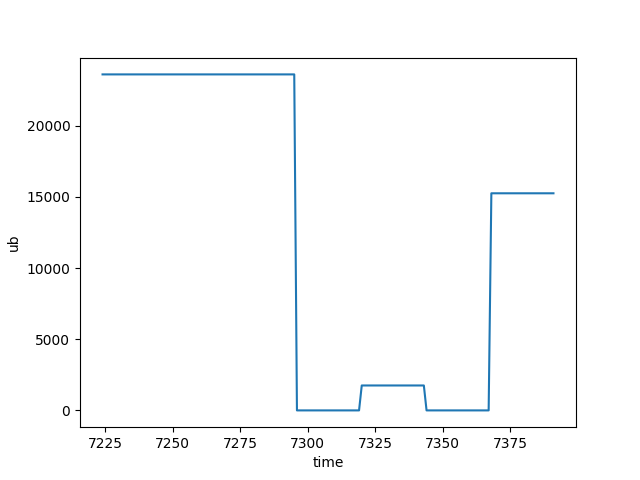

In [23]:
plt.figure()
sns.lineplot(data=df_vars[df_vars.name_var.isin(['HydProd'])&df_vars.name_antares_object.isin(["2_nos0_hydro_open"])],x="time",y="ub")

In [28]:
df_vars[df_vars.name_var.isin(['HydProd'])&df_vars.name_antares_object.isin(["2_nos0_hydro_open"])]

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff
2646,HydProd::area<2_nos0_hydro_open>::hour<7224> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7224>]",HydProd,area,2_nos0_hydro_open,None,7224,hour,C,0.0,23600.000000,0.000982
5329,HydProd::area<2_nos0_hydro_open>::hour<7225> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7225>]",HydProd,area,2_nos0_hydro_open,None,7225,hour,C,0.0,23600.000000,0.000739
8012,HydProd::area<2_nos0_hydro_open>::hour<7226> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7226>]",HydProd,area,2_nos0_hydro_open,None,7226,hour,C,0.0,23600.000000,0.000697
10695,HydProd::area<2_nos0_hydro_open>::hour<7227> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7227>]",HydProd,area,2_nos0_hydro_open,None,7227,hour,C,0.0,23600.000000,-0.000796
13378,HydProd::area<2_nos0_hydro_open>::hour<7228> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7228>]",HydProd,area,2_nos0_hydro_open,None,7228,hour,C,0.0,23600.000000,0.000840
...,...,...,...,...,...,...,...,...,...,...,...,...
439975,HydProd::area<2_nos0_hydro_open>::hour<7387> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7387>]",HydProd,area,2_nos0_hydro_open,None,7387,hour,C,0.0,15249.406894,0.000598
442658,HydProd::area<2_nos0_hydro_open>::hour<7388> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7388>]",HydProd,area,2_nos0_hydro_open,None,7388,hour,C,0.0,15249.406894,0.000581
445341,HydProd::area<2_nos0_hydro_open>::hour<7389> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7389>]",HydProd,area,2_nos0_hydro_open,None,7389,hour,C,0.0,15249.406894,0.000589
448024,HydProd::area<2_nos0_hydro_open>::hour<7390> ...,"[HydProd, area<2_nos0_hydro_open>, hour<7390>]",HydProd,area,2_nos0_hydro_open,None,7390,hour,C,0.0,15249.406894,0.000518


In [33]:
0.127681*5.7328e+07/100*5/24

15249.367433333333

In [ ]:
15249.406894

In [24]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [25]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
0,AreaBalance::area<0_pump_open>::hour<7224> ...,"[AreaBalance, area<0_pump_open>, hour<7224>]",AreaBalance,area,0_pump_open,7224,hour,-100000.000000
1,FictiveLoads::area<0_pump_open>::hour<7224> ...,"[FictiveLoads, area<0_pump_open>, hour<7224>]",FictiveLoads,area,0_pump_open,7224,hour,0.000000
2,AreaBalance::area<0_turb_open>::hour<7224> ...,"[AreaBalance, area<0_turb_open>, hour<7224>]",AreaBalance,area,0_turb_open,7224,hour,0.000000
3,FictiveLoads::area<0_turb_open>::hour<7224> ...,"[FictiveLoads, area<0_turb_open>, hour<7224>]",FictiveLoads,area,0_turb_open,7224,hour,0.000000
4,AreaBalance::area<1_pump_closed>::hour<7224> ...,"[AreaBalance, area<1_pump_closed>, hour<7224>]",AreaBalance,area,1_pump_closed,7224,hour,-100000.000000
...,...,...,...,...,...,...,...,...
66542,HydroPower::area<ro00>::week<43> ...,"[HydroPower, area<ro00>, week<43>]",HydroPower,area,ro00,43,week,77782.563377
66543,HydroPower::area<rs00>::week<43> ...,"[HydroPower, area<rs00>, week<43>]",HydroPower,area,rs00,43,week,26293.386518
66544,HydroPower::area<se03>::week<43> ...,"[HydroPower, area<se03>, week<43>]",HydroPower,area,se03,43,week,289498.840624
66545,HydroPower::area<se04>::week<43> ...,"[HydroPower, area<se04>, week<43>]",HydroPower,area,se04,43,week,38808.000000


In [26]:
df_cons["name_cons"].unique()

array(['AreaBalance', 'FictiveLoads', 'FlowDissociation',
       'HVC_FO_D_AT00_ITN1', 'HVC_FO_D_BE00_DE00', 'HVC_FO_D_BE00_UK00',
       'HVC_FO_D_CH00_ITN1', 'HVC_FO_D_DE00_DKE1', 'HVC_FO_D_DE00_DKW1',
       'HVC_FO_D_DE00_SE04', 'HVC_FO_D_DE00_UK00', 'HVC_FO_D_DEKF_DKKF',
       'HVC_FO_D_DKE1_DKW1', 'HVC_FO_D_DKE1_SE04', 'HVC_FO_D_DKW1_NL00',
       'HVC_FO_D_DKW1_NOS0', 'HVC_FO_D_DKW1_SE03', 'HVC_FO_D_DKW1_UK00',
       'HVC_FO_D_EE00_FI00', 'HVC_FO_D_FI00_SE01', 'HVC_FO_D_FI00_SE03',
       'HVC_FO_D_FR00_ITN1', 'HVC_FO_D_FR00_UK00', 'HVC_FO_D_GR00_ITS1',
       'HVC_FO_D_IE00_UK00', 'HVC_FO_D_ITCA_ITS1', 'HVC_FO_D_ITCA_ITSI',
       'HVC_FO_D_ITCN_ITCS', 'HVC_FO_D_ITCN_ITN1', 'HVC_FO_D_ITCN_ITSA',
       'HVC_FO_D_ITCS_ITS1', 'HVC_FO_D_ITCS_ITSA', 'HVC_FO_D_ITCS_ME00',
       'HVC_FO_D_ITN1_SI00', 'HVC_FO_D_LT00_SE04', 'HVC_FO_D_NL00_UK00',
       'HVC_FO_D_NOM1_SE02', 'HVC_FO_D_NON1_SE01', 'HVC_FO_D_NON1_SE02',
       'HVC_FO_D_NOS0_SE03', 'HVC_FO_D_PL00_SE04', 'HVC_FO_D_SE01_

In [27]:
m.write("problem.lp","l")